<a href="https://colab.research.google.com/github/Anna781421/Ribo-seq/blob/main/Ribo_seq_Python_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ Ribo-seq. Часть 2.

## Задание 2. Анализ wig-файл.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
forward = pd.read_csv('02. RiboSeq_EColi_track_f.wig', sep='\t', skiprows=[0], names=['pos', 'count_for'])
backward = pd.read_csv('02. RiboSeq_EColi_track_r.wig', sep='\t', skiprows=[0], names=['pos', 'count_back'])

wig_data = pd.DataFrame({'pos' : np.arange(40, 4641668+1), 'zero_counts' : [0] * (4641668-40+1)})
wig_data = wig_data.merge(forward, how='outer')
wig_data = wig_data.merge(backward, how='outer')
wig_data.fillna(0, inplace=True)
wig_data['counts'] = wig_data['zero_counts'] + wig_data['count_for'] + wig_data['count_back']
del wig_data['zero_counts']
del wig_data['count_for']
del wig_data['count_back']
wig_data

,pos,counts
0,40,1.0
1,41,0.0
2,42,0.0
3,43,0.0
4,44,0.0
...,...,...
4641624,4641664,0.0
4641625,4641665,0.0
4641626,4641666,0.0
4641627,4641667,0.0


In [4]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.gff.gz
!gunzip GCF_000005845.2_ASM584v2_genomic.gff.gz

--2022-12-12 19:07:09--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.gff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.230, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433547 (423K) [application/x-gzip]
Saving to: ‘GCF_000005845.2_ASM584v2_genomic.gff.gz.2’

GCF_000005845.2_ASM 100%[===================>] 423.39K  1.15MB/s    in 0.4s    

2022-12-12 19:07:10 (1.15 MB/s) - ‘GCF_000005845.2_ASM584v2_genomic.gff.gz.2’ saved [433547/433547]

gzip: GCF_000005845.2_ASM584v2_genomic.gff already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [3]:
ann_data = pd.read_csv('GCF_000005845.2_ASM584v2_genomic.gff', comment='#', sep='\t', names=['seq_ID', 'source', 'type', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
ann_data = ann_data.loc[ann_data['type']=='gene']
ann_data['lenght'] = ann_data['end'] - ann_data['start']
ann_data.head()

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",65
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",2462
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene-b0003;Dbxref=ASAP:ABE-0000010,ECOCYC:E...",932
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene-b0004;Dbxref=ASAP:ABE-0000012,ECOCYC:E...",1286
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene-b0005;Dbxref=ASAP:ABE-0000015,ECOCYC:G...",296


In [4]:
start, end = ann_data['start'][1], ann_data['end'][1]
b0001_gene = wig_data.loc[(wig_data['pos']>=start)&(wig_data['pos']<=end)].copy()
start, end

(190, 255)

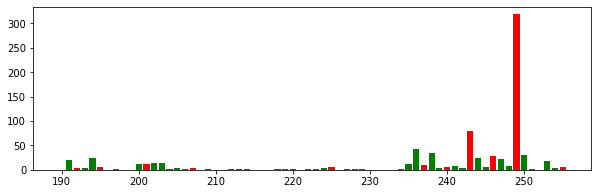

In [5]:
fig, ax = plt.subplots(figsize=(10,3))
x = np.arange(190, 256)
color = ['red' if pos % 3 == 0 else 'green' for pos in x]
plt.bar(x, b0001_gene['counts'], color=color)
plt.show()

Покрытие генома неравномерно. Периодичность в три нуклеотида не выражена. 

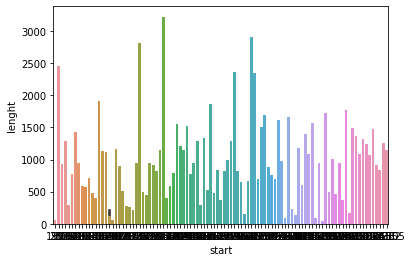

In [7]:
sns.barplot(data=ann_data[0:100], x="start", y="lenght")

In [8]:
data = ann_data.loc[((ann_data['lenght'] > 100) & (ann_data['lenght'] < 200))][['start', 'end', 'lenght']] # Отбиираем участки длиной 100–200 нуклеотидов
data.shape 

(186, 3)

In [9]:
data

,start,end,lenght
36,16751,16903,152
118,59121,59279,158
150,77388,77519,131
182,92485,92658,173
215,111649,111846,197
...,...,...,...
9317,4556574,4556675,101
9319,4556654,4556797,143
9354,4571751,4571915,164
9432,4612128,4612289,161


In [10]:
all_genes = pd.DataFrame({'pos' : np.arange(0, 200)}) # Датасет, куда будем складывать результаты усреднения
for i in data.index: 
  start, end = data['start'][i], data['end'][i] # Начало и конец гена
  gene = pd.DataFrame(wig_data.loc[(wig_data['pos' ]>= start) & (wig_data['pos'] <= end)]['counts']).reset_index(drop=True)
  all_genes['counts {}'.format(i)] = gene['counts'] # Полученное значение каунтов для гена записываем в итоговый датасет 
all_genes.fillna(0, inplace=True)
del all_genes['pos']
all_genes['sum'] = all_genes.sum(axis=1)
all_genes.head()

<ipython-input-10-b2eee6d23144>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  all_genes['counts {}'.format(i)] = gene['counts'] # Полученное значение каунтов для гена записываем в итоговый датасет


,counts 36,counts 118,counts 150,counts 182,counts 215,counts 354,counts 438,counts 608,counts 657,counts 661,...,counts 8939,counts 9002,counts 9138,counts 9206,counts 9317,counts 9319,counts 9354,counts 9432,counts 9484,sum
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2724.0
1,0.0,1.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1633.0
2,0.0,2.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1069.0
3,0.0,5.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,23.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1363.0
4,0.0,0.0,3.0,0.0,1.0,1.0,8.0,0.0,2.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,17925.0


<BarContainer object of 200 artists>

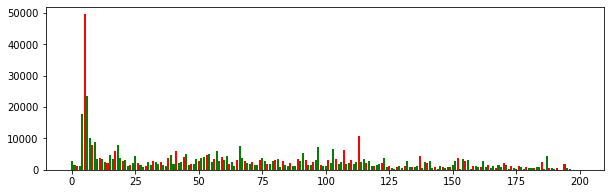

In [11]:
fig, ax = plt.subplots(figsize=(10,3))
x = np.arange(0, 200)
color = ['red' if pos % 3 == 2 else 'green' for pos in x]
ax.bar(x, all_genes['sum'], color=color)

Покрытие генома неравномерно. Периодичность в три нуклеотида выражена на некоторых участках.

# RPKM и TPM

RPKM - Reads Per Kilobase Million;
TPM - Transcripts Per Kilobase Million

RPKM = (number of reads mapped to gene * 10^3 * 10^6) / (total number of mapped reads * gene length in bp)

In [12]:
ann_data

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",65
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",2462
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene-b0003;Dbxref=ASAP:ABE-0000010,ECOCYC:E...",932
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene-b0004;Dbxref=ASAP:ABE-0000012,ECOCYC:E...",1286
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene-b0005;Dbxref=ASAP:ABE-0000015,ECOCYC:G...",296
...,...,...,...,...,...,...,...,...,...,...
9480,NC_000913.3,RefSeq,gene,4638178,4639530,.,+,.,"ID=gene-b4400;Dbxref=ASAP:ABE-0014432,ECOCYC:E...",1352
9482,NC_000913.3,RefSeq,gene,4639590,4640306,.,-,.,"ID=gene-b4401;Dbxref=ASAP:ABE-0014434,ECOCYC:E...",716
9484,NC_000913.3,RefSeq,gene,4640402,4640542,.,+,.,"ID=gene-b4402;Dbxref=ASAP:ABE-0014437,ECOCYC:G...",140
9486,NC_000913.3,RefSeq,gene,4640718,4640771,.,+,.,"ID=gene-b4824;Dbxref=ECOCYC:G0-17098,GeneID:71...",53


In [13]:
reads_per_gene = []
for i in ann_data.index:
  start, end = ann_data['start'][i], ann_data['end'][i] # Начало и конец гена
  reads = wig_data.loc[(wig_data['pos'] >= start) & (wig_data['pos'] <= end)]['counts'].sum(axis=0)
  reads_per_gene.append(reads)
ann_data['reads_per_gene'] = reads_per_gene
ann_data

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght,reads_per_gene
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",65,811.0
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",2462,34301.0
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene-b0003;Dbxref=ASAP:ABE-0000010,ECOCYC:E...",932,6706.0
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene-b0004;Dbxref=ASAP:ABE-0000012,ECOCYC:E...",1286,19619.0
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene-b0005;Dbxref=ASAP:ABE-0000015,ECOCYC:G...",296,160.0
...,...,...,...,...,...,...,...,...,...,...,...
9480,NC_000913.3,RefSeq,gene,4638178,4639530,.,+,.,"ID=gene-b4400;Dbxref=ASAP:ABE-0014432,ECOCYC:E...",1352,30.0
9482,NC_000913.3,RefSeq,gene,4639590,4640306,.,-,.,"ID=gene-b4401;Dbxref=ASAP:ABE-0014434,ECOCYC:E...",716,11509.0
9484,NC_000913.3,RefSeq,gene,4640402,4640542,.,+,.,"ID=gene-b4402;Dbxref=ASAP:ABE-0014437,ECOCYC:G...",140,66.0
9486,NC_000913.3,RefSeq,gene,4640718,4640771,.,+,.,"ID=gene-b4824;Dbxref=ECOCYC:G0-17098,GeneID:71...",53,99.0


RPKM = (number of reads mapped to gene * 10^3 * 10^6) / (total number of mapped reads * gene length in bp)

In [14]:
total_reads = ann_data['reads_per_gene'].sum(axis=0)
ann_data['RPKM'] = (ann_data['reads_per_gene'] * 10**3 * 10**6) / (total_reads * ann_data['lenght'])
ann_data

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght,reads_per_gene,RPKM
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",65,811.0,211.282381
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",2462,34301.0,235.925301
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene-b0003;Dbxref=ASAP:ABE-0000010,ECOCYC:E...",932,6706.0,121.843796
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene-b0004;Dbxref=ASAP:ABE-0000012,ECOCYC:E...",1286,19619.0,258.340016
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene-b0005;Dbxref=ASAP:ABE-0000015,ECOCYC:G...",296,160.0,9.153434
...,...,...,...,...,...,...,...,...,...,...,...,...
9480,NC_000913.3,RefSeq,gene,4638178,4639530,.,+,.,"ID=gene-b4400;Dbxref=ASAP:ABE-0014432,ECOCYC:E...",1352,30.0,0.375751
9482,NC_000913.3,RefSeq,gene,4639590,4640306,.,-,.,"ID=gene-b4401;Dbxref=ASAP:ABE-0014434,ECOCYC:E...",716,11509.0,272.195131
9484,NC_000913.3,RefSeq,gene,4640402,4640542,.,+,.,"ID=gene-b4402;Dbxref=ASAP:ABE-0014437,ECOCYC:G...",140,66.0,7.983102
9486,NC_000913.3,RefSeq,gene,4640718,4640771,.,+,.,"ID=gene-b4824;Dbxref=ECOCYC:G0-17098,GeneID:71...",53,99.0,31.631159


TPM = RPKM / total RPKM by all genes * 10^6

In [15]:
total_RPKM = ann_data['RPKM'].sum(axis=0)
ann_data['TPM'] = ann_data['RPKM'] / total_RPKM * 10**6
ann_data

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght,reads_per_gene,RPKM,TPM
1,NC_000913.3,RefSeq,gene,190,255,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",65,811.0,211.282381,127.311732
3,NC_000913.3,RefSeq,gene,337,2799,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",2462,34301.0,235.925301,142.160735
5,NC_000913.3,RefSeq,gene,2801,3733,.,+,.,"ID=gene-b0003;Dbxref=ASAP:ABE-0000010,ECOCYC:E...",932,6706.0,121.843796,73.419017
7,NC_000913.3,RefSeq,gene,3734,5020,.,+,.,"ID=gene-b0004;Dbxref=ASAP:ABE-0000012,ECOCYC:E...",1286,19619.0,258.340016,155.667097
9,NC_000913.3,RefSeq,gene,5234,5530,.,+,.,"ID=gene-b0005;Dbxref=ASAP:ABE-0000015,ECOCYC:G...",296,160.0,9.153434,5.515555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,NC_000913.3,RefSeq,gene,4638178,4639530,.,+,.,"ID=gene-b4400;Dbxref=ASAP:ABE-0014432,ECOCYC:E...",1352,30.0,0.375751,0.226415
9482,NC_000913.3,RefSeq,gene,4639590,4640306,.,-,.,"ID=gene-b4401;Dbxref=ASAP:ABE-0014434,ECOCYC:E...",716,11509.0,272.195131,164.015728
9484,NC_000913.3,RefSeq,gene,4640402,4640542,.,+,.,"ID=gene-b4402;Dbxref=ASAP:ABE-0014437,ECOCYC:G...",140,66.0,7.983102,4.810352
9486,NC_000913.3,RefSeq,gene,4640718,4640771,.,+,.,"ID=gene-b4824;Dbxref=ECOCYC:G0-17098,GeneID:71...",53,99.0,31.631159,19.059884


In [16]:
def gene_name(attribute):
  gene = attribute.split('gene=')
  
  return gene[1].split(';')[0]

In [17]:
ATP_data = ann_data.loc[ann_data['attribute'].str.contains('atp')].copy()
ATP_data['gene'] = ATP_data['attribute'].apply(gene_name)
ATP_data

,seq_ID,source,type,start,end,score,strand,frame,attribute,lenght,reads_per_gene,RPKM,TPM,gene
8036,NC_000913.3,RefSeq,gene,3915553,3915972,.,-,.,"ID=gene-b3731;Dbxref=ASAP:ABE-0012206,ECOCYC:E...",419,11576.0,467.843155,281.906717,atpC
8038,NC_000913.3,RefSeq,gene,3915993,3917375,.,-,.,"ID=gene-b3732;Dbxref=ASAP:ABE-0012208,ECOCYC:E...",1382,84139.0,1030.967767,621.226870,atpD
8040,NC_000913.3,RefSeq,gene,3917402,3918265,.,-,.,"ID=gene-b3733;Dbxref=ASAP:ABE-0012211,ECOCYC:E...",863,12618.0,247.591375,149.190324,atpG
8042,NC_000913.3,RefSeq,gene,3918316,3919857,.,-,.,"ID=gene-b3734;Dbxref=ASAP:ABE-0012213,ECOCYC:E...",1541,73134.0,803.660222,484.258907,atpA
8044,NC_000913.3,RefSeq,gene,3919870,3920403,.,-,.,"ID=gene-b3735;Dbxref=ASAP:ABE-0012215,ECOCYC:E...",533,9441.0,299.948416,180.738934,atpH
8046,NC_000913.3,RefSeq,gene,3920418,3920888,.,-,.,"ID=gene-b3736;Dbxref=ASAP:ABE-0012217,ECOCYC:E...",470,12632.0,455.124320,274.242771,atpF
8048,NC_000913.3,RefSeq,gene,3920950,3921189,.,-,.,"ID=gene-b3737;Dbxref=ASAP:ABE-0012220,ECOCYC:E...",239,71395.0,5058.545738,3048.111333,atpE
8050,NC_000913.3,RefSeq,gene,3921236,3922051,.,-,.,"ID=gene-b3738;Dbxref=ASAP:ABE-0012222,ECOCYC:E...",815,22903.0,475.872434,286.744894,atpB
8052,NC_000913.3,RefSeq,gene,3922060,3922440,.,-,.,"ID=gene-b3739;Dbxref=ASAP:ABE-0012224,ECOCYC:E...",380,511.0,22.771576,13.721394,atpI


9 генов присутствуют в ATP опероне, координаты оперона 3915553-3922440. 

Наибольшее покрытие имеют гены, кодирующие α и β субъединицы и ротор c, наименьшее - гены, кодирующие γ, δ. 

Ribo-Seq оценивает трансляцию, поэтому на его данных разница должна быть более заметна, чем на RNA-Seq. 